In [1]:
from __future__ import absolute_import, division, print_function

import os
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
from six.moves import urllib

In [2]:
#!pip install -q tensorflow==2.0.0-alpha0
import tensorflow.compat.v2.feature_column as fc

import tensorflow as tf

Limited tf.compat.v2.summary API due to missing TensorBoard installation
Limited tf.summary API due to missing TensorBoard installation
Limited tf.compat.v2.summary API due to missing TensorBoard installation


In [3]:
# Load dataset.
dftrain = pd.read_csv('train_titanic.csv')
dfeval = pd.read_csv('eval_titanic.csv')
y_train = dftrain.pop('survived')
y_eval = dfeval.pop('survived')

In [4]:
dftrain.head()

,Unnamed: 0,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n
1,1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
2,2,female,26.0,0,0,7.9250,Third,unknown,Southampton,y
3,3,female,35.0,1,0,53.1000,First,C,Southampton,n
4,4,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y


In [5]:
dftrain.describe()

,Unnamed: 0,age,n_siblings_spouses,parch,fare
count,627.000000,627.000000,627.000000,627.000000,627.000000
mean,313.000000,29.631308,0.545455,0.379585,34.385399
std,181.143589,12.511818,1.151090,0.792999,54.597730
min,0.000000,0.750000,0.000000,0.000000,0.000000
25%,156.500000,23.000000,0.000000,0.000000,7.895800
50%,313.000000,28.000000,0.000000,0.000000,15.045800
75%,469.500000,35.000000,1.000000,0.000000,31.387500
max,626.000000,80.000000,8.000000,5.000000,512.329200


In [6]:
dftrain.shape[0], dfeval.shape[0]

(627, 264)

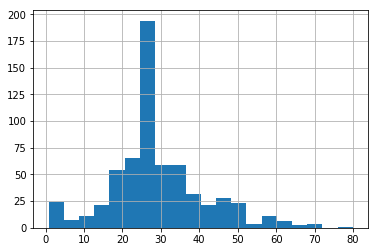

In [7]:
dftrain.age.hist(bins=20)

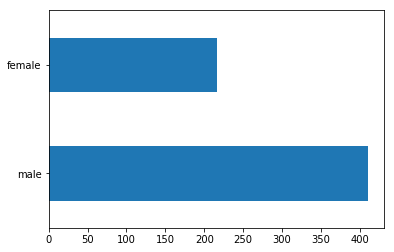

In [8]:
dftrain.sex.value_counts().plot(kind='barh')

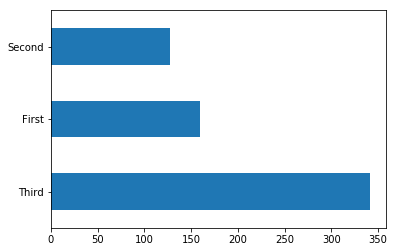

In [9]:
dftrain['class'].value_counts().plot(kind='barh')

Text(0.5, 0, '% survive')

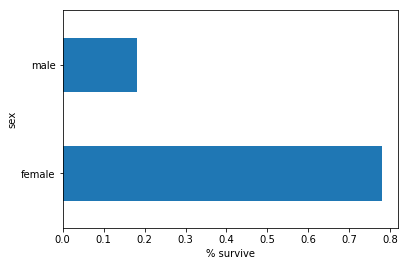

In [10]:
pd.concat([dftrain, y_train], axis=1).groupby('sex').survived.mean().plot(kind='barh').set_xlabel('% survive')

In [11]:
CATEGORICAL_COLUMNS = ['sex', 'n_siblings_spouses', 'parch', 'class', 'deck', 
                       'embark_town', 'alone']
NUMERIC_COLUMNS = ['age', 'fare']

feature_columns = []
for feature_name in CATEGORICAL_COLUMNS:
  vocabulary = dftrain[feature_name].unique()
  feature_columns.append(tf.feature_column.categorical_column_with_vocabulary_list(feature_name, vocabulary))
  
for feature_name in NUMERIC_COLUMNS:
  feature_columns.append(tf.feature_column.numeric_column(feature_name, dtype=tf.float32))

In [12]:
def make_input_fn(data_df, label_df, num_epochs=10, shuffle=True, batch_size=32):
  def input_function():
    ds = tf.data.Dataset.from_tensor_slices((dict(data_df), label_df))
    if shuffle:
      ds = ds.shuffle(1000)
    ds = ds.batch(batch_size).repeat(num_epochs)
    return ds
  return input_function

train_input_fn = make_input_fn(dftrain, y_train)
eval_input_fn = make_input_fn(dfeval, y_eval, num_epochs=1, shuffle=False)

In [13]:
ds = make_input_fn(dftrain, y_train, batch_size=10)()
for feature_batch, label_batch in ds.take(1):
  print('Some feature keys:', list(feature_batch.keys()))
  print()
  print('A batch of class:', feature_batch['class'].numpy())
  print()
  print('A batch of Labels:', label_batch.numpy())

Some feature keys: ['Unnamed: 0', 'sex', 'age', 'n_siblings_spouses', 'parch', 'fare', 'class', 'deck', 'embark_town', 'alone']

A batch of class: [b'Second' b'First' b'First' b'First' b'Second' b'Third' b'Third' b'Third'
 b'Second' b'Third']

A batch of Labels: [1 1 0 1 0 0 0 1 1 0]


In [14]:
age_column = feature_columns[7]
tf.keras.layers.DenseFeatures([age_column])(feature_batch).numpy()

W0324 16:15:52.049490 140142884390720 deprecation.py:323] From /home/rohan/miniconda3/envs/deep_learning_tf/lib/python3.6/site-packages/tensorflow/python/feature_column/feature_column_v2.py:2758: to_float (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.cast` instead.


array([[19.],
       [49.],
       [37.],
       [21.],
       [23.],
       [28.],
       [28.],
       [ 4.],
       [34.],
       [30.]], dtype=float32)

In [15]:
gender_column = feature_columns[0]
tf.keras.layers.DenseFeatures([tf.feature_column.indicator_column(gender_column)])(feature_batch).numpy()

W0324 16:16:03.906383 140142884390720 deprecation.py:323] From /home/rohan/miniconda3/envs/deep_learning_tf/lib/python3.6/site-packages/tensorflow/python/ops/lookup_ops.py:1347: to_int64 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.cast` instead.
W0324 16:16:03.908299 140142884390720 deprecation.py:323] From /home/rohan/miniconda3/envs/deep_learning_tf/lib/python3.6/site-packages/tensorflow/python/feature_column/feature_column_v2.py:4307: IndicatorColumn._variable_shape (from tensorflow.python.feature_column.feature_column_v2) is deprecated and will be removed in a future version.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
W0324 16:16:03.908863 140142884390720 deprecation.py:323] From /home/rohan/miniconda3/envs/deep_learning_tf/lib/python3.6/site-packages/tensorflow/python/feature_column/feature_column_v2.py:4362: Vocabular

array([[0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.]], dtype=float32)

In [16]:
linear_est = tf.estimator.LinearClassifier(feature_columns=feature_columns)
linear_est.train(train_input_fn)
result = linear_est.evaluate(eval_input_fn)

clear_output()
print(result)

{'accuracy': 0.74242425, 'accuracy_baseline': 0.625, 'auc': 0.83529234, 'auc_precision_recall': 0.78677535, 'average_loss': 0.4776684, 'label/mean': 0.375, 'loss': 0.46974373, 'precision': 0.65048546, 'prediction/mean': 0.4094172, 'recall': 0.67676765, 'global_step': 200}


In [17]:
age_x_gender = tf.feature_column.crossed_column(['age', 'sex'], hash_bucket_size=100)

In [18]:
derived_feature_columns = [age_x_gender]
linear_est = tf.estimator.LinearClassifier(feature_columns=feature_columns+derived_feature_columns)
linear_est.train(train_input_fn)
result = linear_est.evaluate(eval_input_fn)

clear_output()
print(result)

{'accuracy': 0.7613636, 'accuracy_baseline': 0.625, 'auc': 0.84132236, 'auc_precision_recall': 0.7881202, 'average_loss': 0.5179977, 'label/mean': 0.375, 'loss': 0.51458406, 'precision': 0.65, 'prediction/mean': 0.4910912, 'recall': 0.7878788, 'global_step': 200}


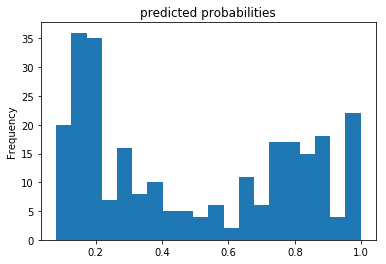

In [19]:
pred_dicts = list(linear_est.predict(eval_input_fn))
probs = pd.Series([pred['probabilities'][1] for pred in pred_dicts])

probs.plot(kind='hist', bins=20, title='predicted probabilities')

(0, 1.05)

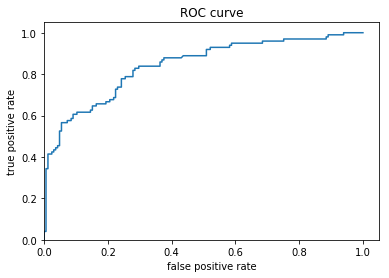

In [20]:
from sklearn.metrics import roc_curve
from matplotlib import pyplot as plt

fpr, tpr, _ = roc_curve(y_eval, probs)
plt.plot(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.xlim(0,)
plt.ylim(0,)